In [1]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 10.4 MB/s eta 0:00:00


## Import all module

In [2]:
import pandas as pd
import numpy as np
import unicodedata
import re
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, Attention
from tensorflow.keras.models import Model
from keras.layers import Embedding
import matplotlib.pyplot as plt
import contractions

In [3]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)


tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [4]:
from contractions import contractions_dict
for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [5]:
def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    
    # Replace newlines with spaces
    text = re.sub(r'\n', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Keep only comma, fullstop, text, and numbers
    text = re.sub(r'[^\w\s]', '', text)

    return text

In [6]:
# Load data
df = pd.read_csv('/kaggle/input/news-summary/news_summary.csv', encoding='iso-8859-1')
df.size

27084

In [7]:
df.sample(5)

,author,date,headlines,read_more,text,ctext
1488,Mansha Mahajan,"20 Jan 2017,Friday",Trump's going to fail and Theresa May won't la...,https://www.theguardian.com/business/2017/jan/...,Billionaire investor George Soros said that UK...,Theresa May will not remain in power long as B...
2583,Saloni Tandon,"11 Jul 2017,Tuesday",Dravid to be India's batting consultant for ov...,http://indiatoday.intoday.in/story/ravi-shastr...,Former captain Rahul Dravid has been appointed...,Former captain Ravi Shastri has been appointed...
1420,Vaibhav Gupta,"26 Jan 2017,Thursday",SEBI bars Vijay Mallya from securities market,http://indiatoday.intoday.in/story/sebi-bars-v...,Market Regulator Securities and Exchange Board...,NaN
923,Arshiya Chopra,"19 Jul 2017,Wednesday",Tamil Nadu almost doubles MLAs' salary to over...,http://www.hindustantimes.com/india-news/tamil...,Tamil Nadu government has almost doubled the s...,The Tamil Nadu government on Wednesday raised ...
2470,Dishant Sharma,"13 Jul 2017,Thursday",Indian women's hockey team reaches HWL Semi-Fi...,http://www.hindustantimes.com/other-sports/hoc...,The Indian women's hockey team reached the qua...,Indian Women?s Hockey team secured a hard-foug...


In [8]:
df = df.dropna()
df.size

26376

In [9]:
for col in df:
    df[col] = df[col].map(str)

In [10]:
df_train = pd.DataFrame()

In [11]:
df_train['text'] = df['ctext'].apply(lambda x: x.lower())
df_train['summary'] = df['text'].apply(lambda x: x.lower())

In [12]:
df_train.size

8792

In [13]:
df_train['text'] =  df_train['text'].apply(clean_text)
df_train['summary'] =  df_train['summary'].apply(clean_text)

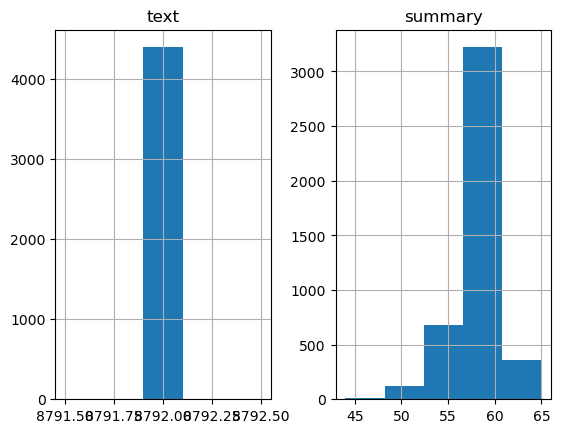

In [14]:
text_count = []
summary_count = []
for words in df_train['text']:
    text_count.append(df_train.size)
for words in df_train['summary']:
    summary_count.append(len(words.split()))
graph_df = pd.DataFrame()
graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

# Preprocess text

In [15]:
max_text_len = 300
max_summary_len = 60
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(df_train['text'])
summary_tokenizer = Tokenizer()
summary_tokenizer.fit_on_texts(df_train['summary'])
text_vocab_size = len(text_tokenizer.word_index) + 1
summary_vocab_size = len(summary_tokenizer.word_index) + 1


### Create input and target sequences

In [16]:
text_sequences = text_tokenizer.texts_to_sequences(df_train['text'])
text_sequences_padded = pad_sequences(text_sequences, maxlen=max_text_len, padding='post')
summary_sequences = summary_tokenizer.texts_to_sequences(df_train['summary'])
summary_sequences_padded = pad_sequences(summary_sequences, maxlen=max_text_len+1, padding='post')

# Define model

In [17]:
encoder_inputs = Input(shape=(None,))
encoder_embed = Embedding(text_vocab_size, 300, trainable=True)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(300, return_sequences=True, dropout=0.2))(encoder_embed)
encoder_states = [encoder_lstm[:, i, :] for i in range(2)]

In [18]:
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(summary_vocab_size, 300, trainable=True)
decoder_embed = decoder_embedding(decoder_inputs)
decoder_lstm = Bidirectional(LSTM(300, return_sequences=True, dropout=0.2))(decoder_embed)

In [19]:
attention = Attention()([encoder_lstm, decoder_lstm])
decoder_concat = Concatenate()([decoder_lstm, attention])
decoder_dense = Dense(summary_vocab_size, activation='softmax')(decoder_concat)

model = Model([encoder_inputs, decoder_inputs], decoder_dense)

In [20]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    6588900     ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, None, 300)    23987400    ['input_1[0][0]']                
                                                                                              

In [22]:
# Train model
history=model.fit([text_sequences_padded, summary_sequences_padded[:,:-1]], summary_sequences_padded[:,1:],validation_split=0.2, batch_size=128, epochs=100,callbacks=[early_stopping])

Epoch 1/100
55/55 [==============================] - 35s 424ms/step - loss: 5.1965 - accuracy: 0.4193 - val_loss: 4.3894 - val_accuracy: 0.4360
Epoch 2/100
55/55 [==============================] - 19s 353ms/step - loss: 4.3352 - accuracy: 0.4495 - val_loss: 4.3156 - val_accuracy: 0.4562
Epoch 3/100
55/55 [==============================] - 19s 340ms/step - loss: 4.2727 - accuracy: 0.4564 - val_loss: 4.2840 - val_accuracy: 0.4590
Epoch 4/100
55/55 [==============================] - 18s 332ms/step - loss: 4.2463 - accuracy: 0.4585 - val_loss: 4.2735 - val_accuracy: 0.4577
Epoch 5/100
55/55 [==============================] - 18s 335ms/step - loss: 4.2296 - accuracy: 0.4595 - val_loss: 4.2714 - val_accuracy: 0.4590
Epoch 6/100
55/55 [==============================] - 18s 330ms/step - loss: 4.2166 - accuracy: 0.4603 - val_loss: 4.2586 - val_accuracy: 0.4591
Epoch 7/100
55/55 [==============================] - 18s 332ms/step - loss: 4.2020 - accuracy: 0.4619 - val_loss: 4.2428 - val_accuracy:

In [23]:
model.save("modelfinal.h5")

### Plot accuracy history

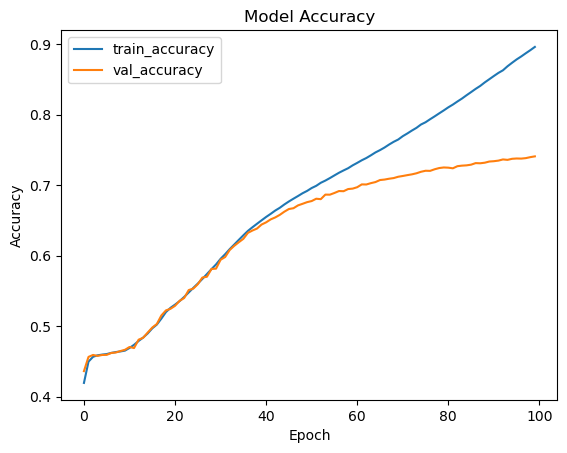

In [24]:
# Plot accuracy history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Plot loss history

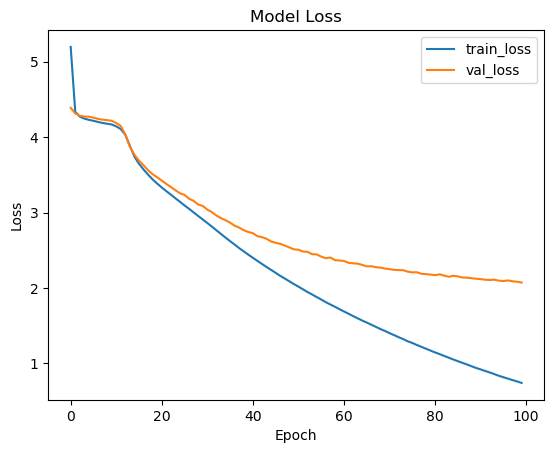

In [25]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
test_df = pd.read_csv('/kaggle/input/d/sunnysai12345/news-summary/news_summary.csv', encoding='iso-8859-1')

In [34]:
def generate_summary(text):
    # Tokenize the input text
    x = text_tokenizer.texts_to_sequences([text])
    # Pad the tokenized sequences
    x = pad_sequences(x, maxlen=max_text_len, padding='post')

    # Initialize the summary sequence with a start token
    summary_seq = np.zeros((1, max_text_len))
    summary_seq[0, 0] = summary_tokenizer.word_index['start']

    # Generate the summary
    for i in range(1, max_summary_len):
        output_tokens = model.predict([x, summary_seq]).argmax(axis=2)
        summary_seq[0, i] = output_tokens[0, i-1]
        index_word = summary_tokenizer.index_word.get(summary_seq[0, i])
        if index_word and index_word == 'end':
            break

    # Convert the summary sequence back to text
    summary = ' '.join([summary_tokenizer.index_word[w] for w in summary_seq[0] if w not in [0, summary_tokenizer.word_index['start'], summary_tokenizer.word_index['end']]])
    return summary


In [33]:
for idx in range(10,18):
    text = clean_text(test_df['text'][idx])
    summary = clean_text(test_df['summary'][idx])
    preprocess_text = clean_text(text)
    output = generate_summary(test_df['text'][idx])
    print ("\n\n original text: \n", text)
    print ("\n\n original Summary: \n",summary)
    print ("\n\nPredicted Summary: \n",output)



 original text: 
 the food safety and standards authority of india fssai is in the process of creating a network of food banking partners to collect and distribute leftover food from large parties and weddings to the hungrya notification to create a separate category of food business operators fbos who will be licensed to deal only with leftover food has been drafted to ensure the quality of foodwe are looking at partnering with ngos or organisations that collect store and distribute surplus food to ensure they maintain certain hygiene and health standards when handling food said pawan agarwal ceo of fssaitonnes of food is wasted annually we are looking at creating a mechanism through which food can be collected from restaurants weddings largescale parties says pawan agarwal all food whether it is paid for or distributed free must meet the countrys food safety and hygiene standards he saidthe organisations in the business of collecting leftover food will now have to work in collabora